In [1]:
import requests
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.multioutput import MultiOutputClassifier
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import LabelBinarizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
#Download dataset 
filename1 = r"adult.csv"


In [3]:
#Create dataframe
columns_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]

df = pd.read_csv(filename1, header=0, skip_blank_lines=True, names=columns_names)

df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
#Data handling
#Replace missing Data
def df_replace_nan(df):
    for col_name in df.columns:
        # Directly check if '?' exists in the column
        if df[col_name].dtype == object and '?' in df[col_name].unique():
            # Convert to numeric, forcing errors to NaN
            df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
            # Calculate mean only if needed
            if df[col_name].isnull().any():
                mean_val = df[col_name].mean()
                df[col_name].fillna(mean_val, inplace=True)
        else:
            # Fill NaNs with mode of the column for non-numeric types if necessary
            if df[col_name].isnull().any():
                mode_val = df[col_name].mode().iloc[0]
                df[col_name].fillna(mode_val, inplace=True)
def arr_replace_nan(arr):
    for col_name in arr.dtype.names:
        col = arr[col_name]
        # Check for '?' and replace
        is_question = col == '?'
        if np.any(is_question):
            col = pd.to_numeric(col, errors='coerce')
            mean_val = np.nanmean(col)
            col[np.isnan(col)] = mean_val
            arr[col_name] = col
        else:
            # Convert all values to floats if not already
            arr[col_name] = col.astype(float)

arr = df.to_numpy()
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


salary
<=50K    37155
>50K     11687
Name: count, dtype: int64


<Axes: ylabel='count'>

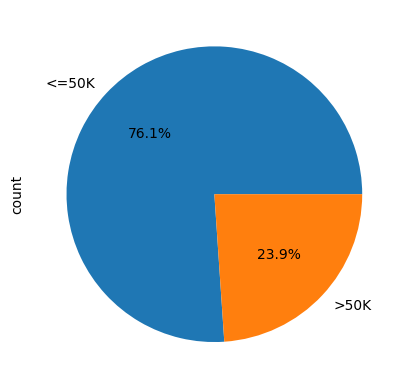

In [5]:
print(df['salary'].value_counts())
df['salary'].value_counts().plot.pie(autopct='%1.1f%%')

In [6]:
#Normalization and OneHot Encoding
norm_map = {
    'age': 'standartization', 'workclass': 'onehot', 'fnlwgt': 'normalization', 'education': 'onehot', 
    'education-num': 'standartization', 'marital-status': 'onehot', 'occupation': 'onehot', 'relationship': 'onehot', 
    'race': 'onehot', 'sex': 'onehot', 'capital-gain': 'normalization', 'capital-loss': 'normalization', 
    'hours-per-week': 'standartization', 'native-country': 'onehot', 'salary': 'onehot'
}

def df_norm_standart_onehot(dataframe):
    result = dataframe.copy()
    for feature_name in dataframe.columns:
        if norm_map[feature_name] == "normalization":
            max_value = dataframe[feature_name].max()
            min_value = dataframe[feature_name].min()
            result[feature_name] = (dataframe[feature_name] - min_value) / (max_value - min_value)
        if norm_map[feature_name] == "standartization":
            mean_value = dataframe[feature_name].mean()
            std_value = dataframe[feature_name].std()
            result[feature_name] = (dataframe[feature_name] - mean_value) / std_value
        if norm_map[feature_name] == "onehot":
            dummies = pd.get_dummies(dataframe[[feature_name]])
            result = pd.concat([result, dummies], axis=1)
            result = result.drop([feature_name], axis=1)
    return result

def arr_norm_standart_onehot(array):
    result = np.copy(array)
    for i, feature_name in enumerate(norm_map.keys()):
        if norm_map[feature_name] == "normalization":
            max_value = array[:, i].max()
            min_value = array[:, i].min()
            result[:, i] = (array[:, i] - min_value) / (max_value - min_value)
        if norm_map[feature_name] == "standartization":
            mean_value = array[:, i].mean()
            std_value = array[:, i].std()
            result[:, i] = (array[:, i] - mean_value) / std_value
        if norm_map[feature_name] == "onehot":
            dummies = pd.get_dummies(array[:, i]).to_numpy()
            result = np.hstack((result, dummies))
    return result

norm_df = df_norm_standart_onehot(df)
norm_arr = norm_df.to_numpy()

norm_df.head()


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,salary_<=50K,salary_>50K
0,-0.995119,0.145129,-1.197247,0.000000,0.0,-0.034087,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
1,-0.046941,0.052451,-0.419331,0.000000,0.0,0.772922,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,-0.776309,0.219649,0.747543,0.000000,0.0,-0.034087,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True
3,0.390679,0.100153,-0.030373,0.076881,0.0,-0.034087,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,-1.505676,0.061708,-0.030373,0.000000,0.0,-0.841095,True,False,False,False,...,False,False,False,False,False,True,False,False,True,False


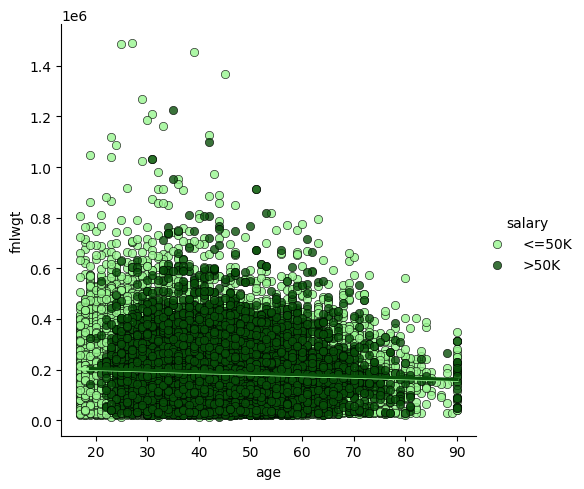

In [7]:
#Graphs to show how features depend on each other
green_palette = {"<=50K": "#99f590", ">50K": "#084f09"}
lp = sns.lmplot(x='age', y='fnlwgt', hue='salary', palette=green_palette, height=5,data=df, fit_reg=True, legend=True,
                scatter_kws=dict(edgecolor="k", linewidths=0.5))

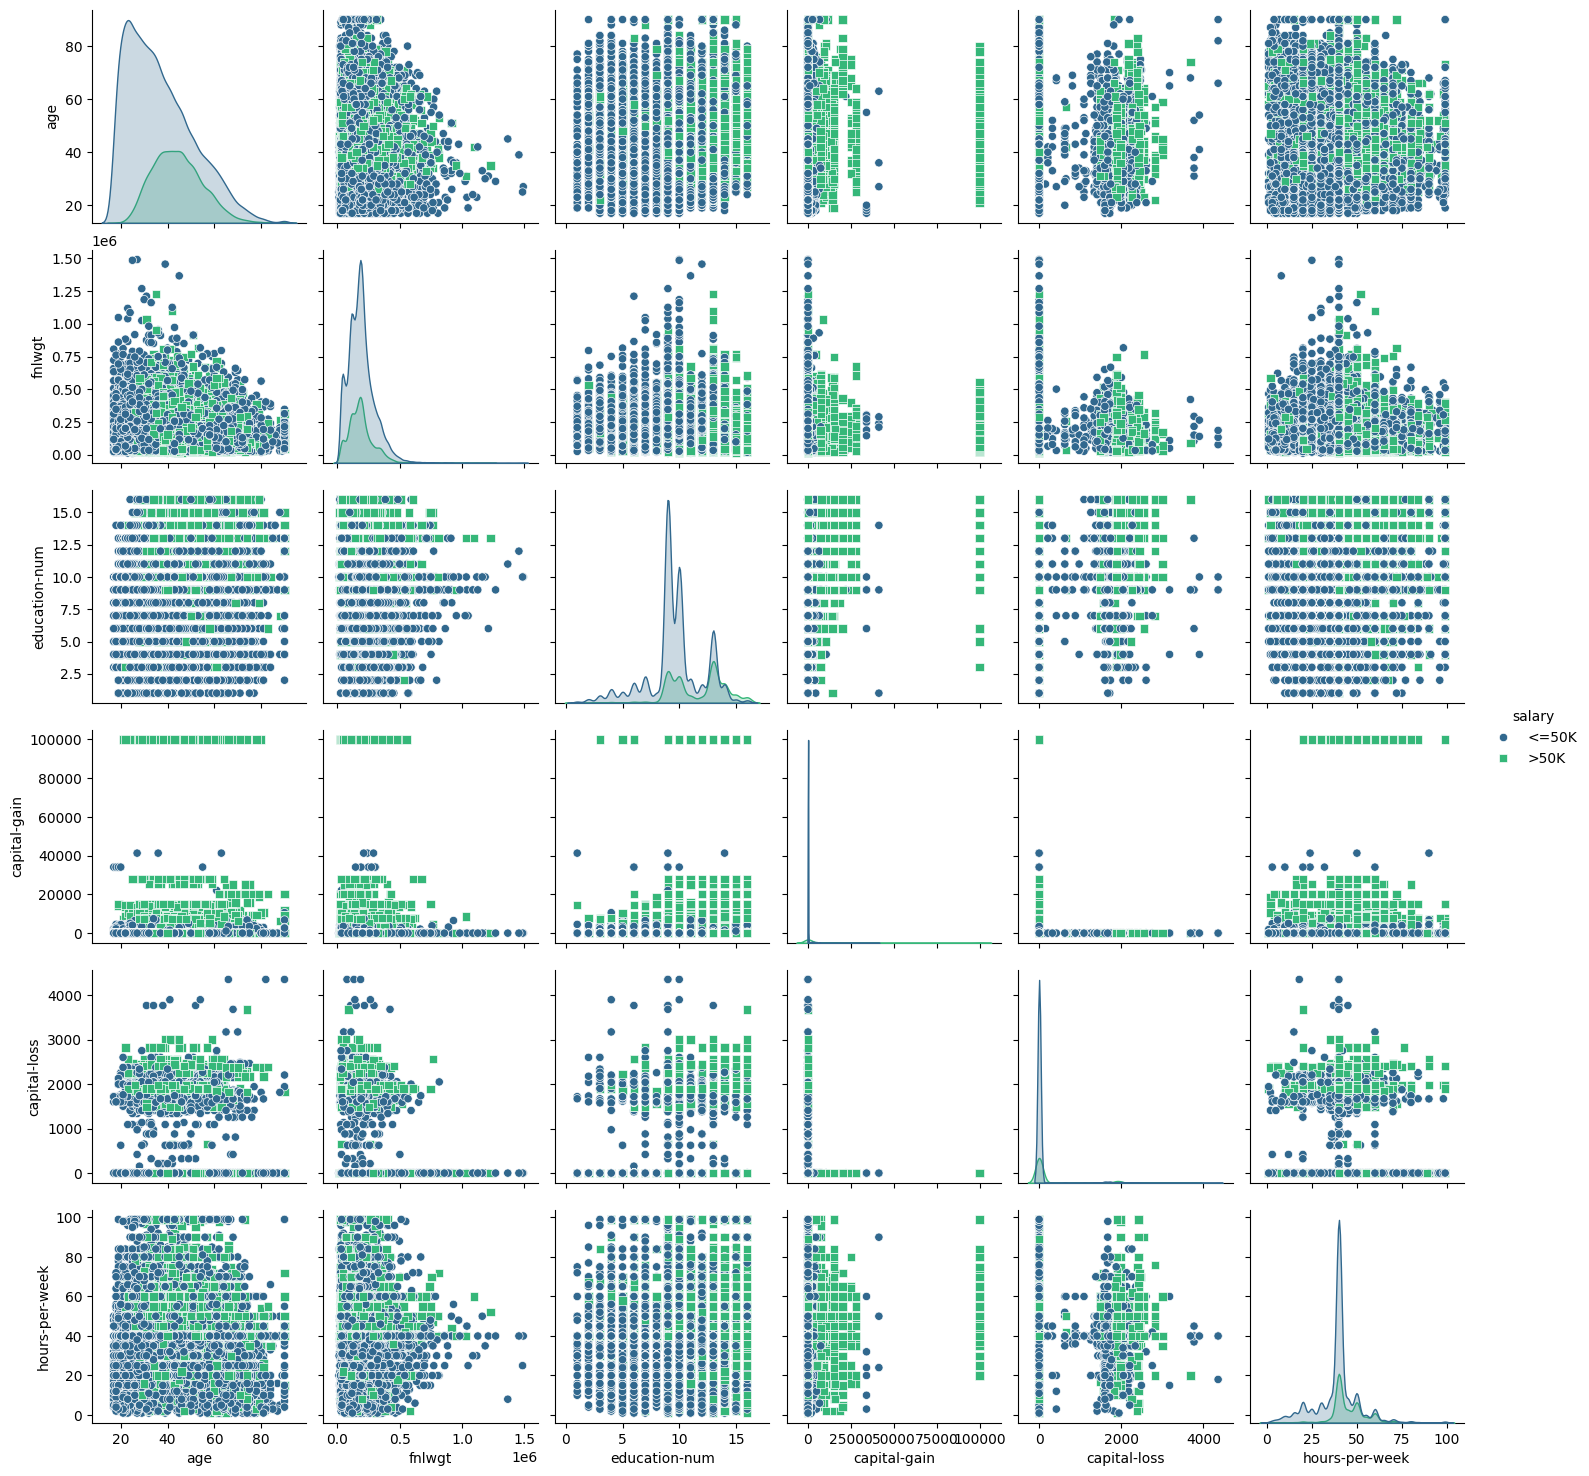

In [8]:
# sns.pairplot(df, hue='salary', vars=['age', 'fnlwgt', 'education-num', 'hours-per-week'], palette='husl')
sns.pairplot(df, hue = 'salary', palette="viridis", markers=["o", "s"])

In [9]:
#Numerical and Categorical features divisio
numerical_features = [features for features in df.columns if df[features].dtype != 'object']
categorical_features = [features for features in df.columns if df[features].dtype == 'object']
print('Numerical Features: ', numerical_features)
print('Categorical Features: ', categorical_features)

Numerical Features:  ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical Features:  ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'salary']


In [10]:
#Correlation
corr = df[numerical_features].corr(method='spearman')
corr

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.077504,0.063212,0.124436,0.057584,0.146604
fnlwgt,-0.077504,1.000000,-0.029643,-0.008755,-0.000944,-0.016334
education-num,0.063212,-0.029643,1.000000,0.118871,0.077017,0.164437
capital-gain,0.124436,-0.008755,0.118871,1.000000,-0.066328,0.091914
capital-loss,0.057584,-0.000944,0.077017,-0.066328,1.000000,0.060063
hours-per-week,0.146604,-0.016334,0.164437,0.091914,0.060063,1.000000


In [11]:
#Correlation
corr = df[numerical_features].corr(method='kendall')
corr

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.052383,0.050856,0.100677,0.047058,0.111001
fnlwgt,-0.052383,1.000000,-0.021378,-0.007001,-0.000771,-0.011818
education-num,0.050856,-0.021378,1.000000,0.103358,0.067488,0.129756
capital-gain,0.100677,-0.007001,0.103358,1.000000,-0.064311,0.079971
capital-loss,0.047058,-0.000771,0.067488,-0.064311,1.000000,0.052643
hours-per-week,0.111001,-0.011818,0.129756,0.079971,0.052643,1.000000


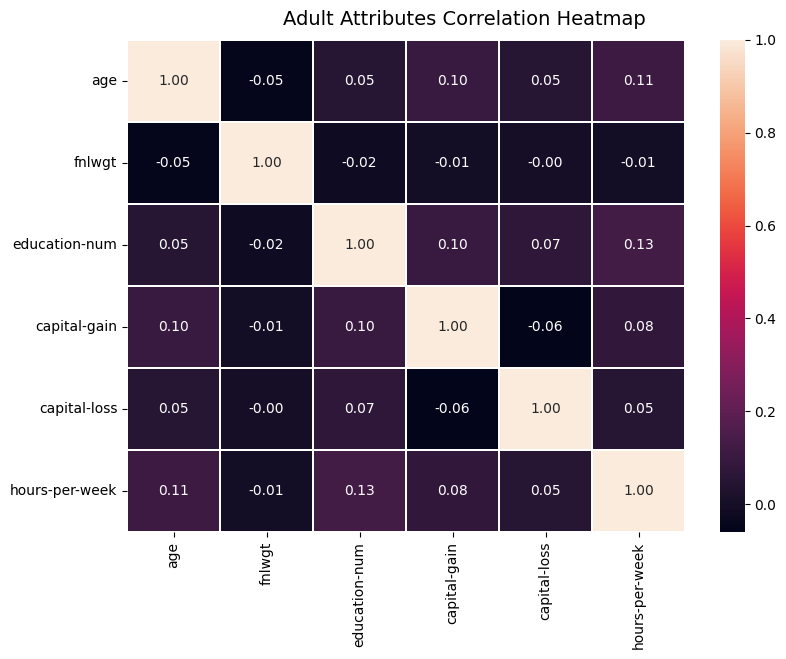

In [12]:
#Correlation visualization for Pearson Coefficient
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(9, 6))
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="rocket", fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Adult Attributes Correlation Heatmap', fontsize=14)

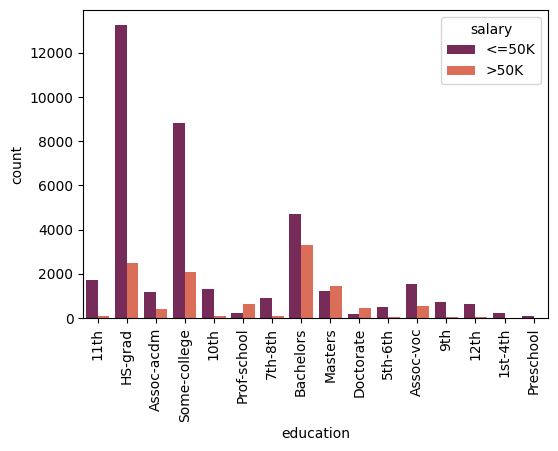

In [13]:
#Barplots
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(1, 1, 1)
cp = sns.countplot(x="education", hue="salary", data=df, palette='rocket', ax=ax)
# Rotate x-axis labels vertically
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate labels to 90 degrees
plt.show()

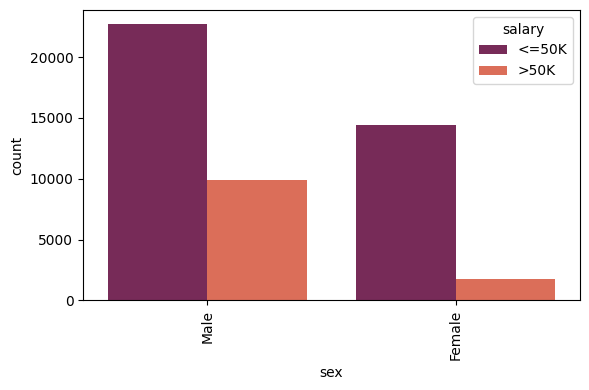

In [14]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(1, 1, 1)
cp = sns.countplot(x="sex", hue="salary", data=df, palette='rocket', ax=ax)
# Rotate x-axis labels vertically
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate labels to 90 degrees

plt.tight_layout()  # Optional: adjust subplots to give some padding
plt.show()

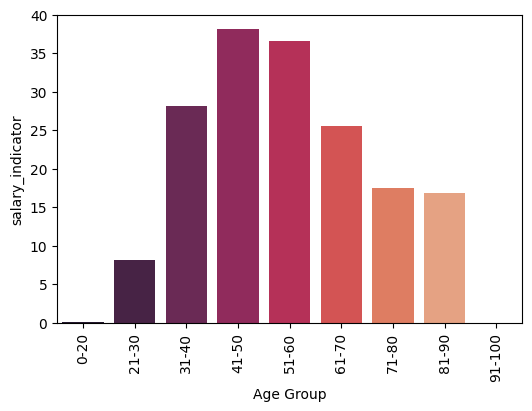

In [15]:
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])

# Convert 'salary' to binary indicator for easier aggregation in sns.barplot
df['salary_indicator'] = df['salary'].apply(lambda x: 1 if x == '>50K' else 0)

# Using sns.barplot to calculate the mean, which is equivalent to the proportion
plt.figure(figsize=(6, 4))
sns.barplot(x='age_group', y='salary_indicator', data=df, estimator=lambda x: sum(x)*100.0/len(x), 
            ci=None, palette = 'rocket')

# Labeling and plotting
plt.xlabel('Age Group')
plt.xticks(rotation=90)  # Rotate for better readability if necessary
plt.show()

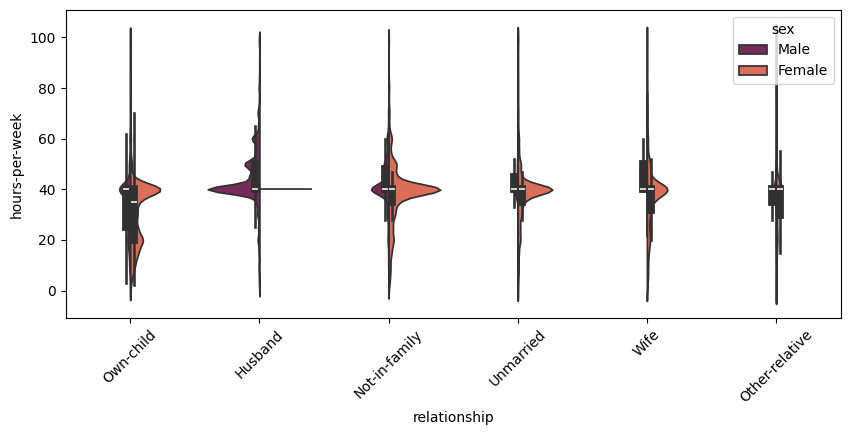

In [16]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
vp = sns.violinplot(x="relationship", y="hours-per-week", hue="sex", data=df, palette='rocket', split=True, scale="count", ax=ax)



Text(0.5, 1.0, 'Occupation Distribution')

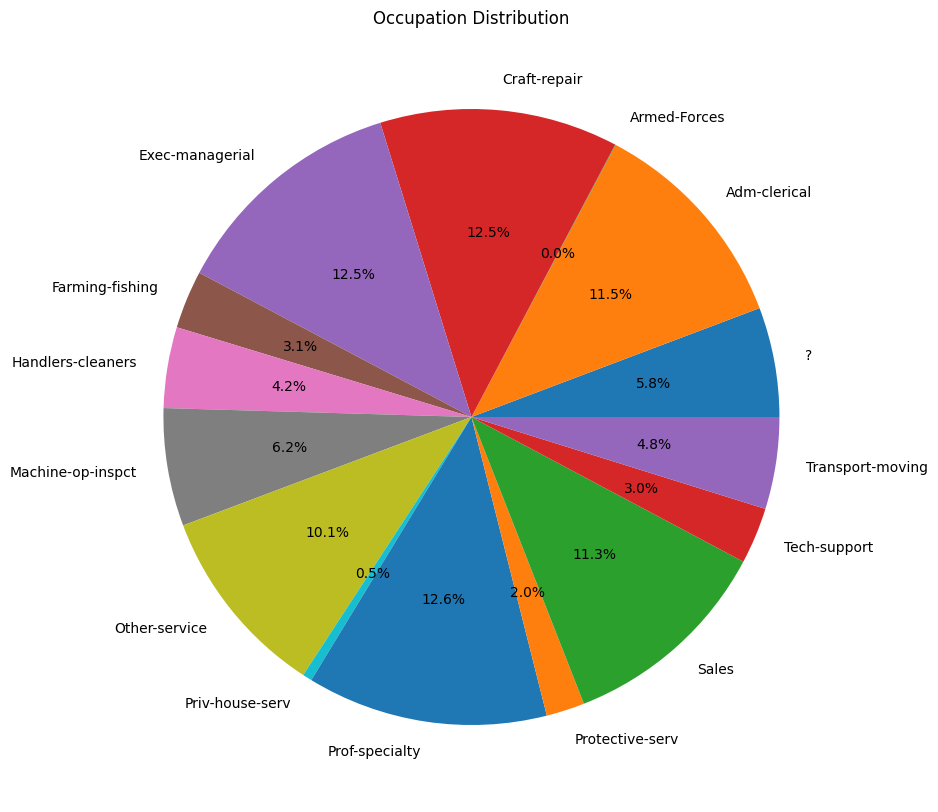

In [17]:
plt.figure(figsize=(12, 10))
plt.pie(df.groupby('occupation').size(), labels=df.groupby('occupation').size().index, autopct='%1.1f%%')
plt.title('Occupation Distribution')

In [18]:
label_encoder = LabelEncoder()
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'salary']
df[categorical_columns] = df[categorical_columns].apply(label_encoder.fit_transform)

In [19]:

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['salary','age_group']), df['salary'], test_size=0.2, random_state=42)

In [20]:
# Identifying numeric features
numeric_features = x_train.select_dtypes(include=[np.number]).columns

# Applying StandardScaler only to numeric features
scaler = StandardScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

# Scale numeric features only
x_train_scaled[numeric_features] = scaler.fit_transform(x_train[numeric_features])
x_test_scaled[numeric_features] = scaler.transform(x_test[numeric_features])

In [21]:
#Train, Test, Validation
s_names = ['salary_<=50K',	'salary_>50K']

X = norm_df.drop(columns=s_names).to_numpy()
Y = norm_df[s_names].to_numpy()
print("X shape: " + str(X.shape))
print("Y shape: " + str(Y.shape))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42)
print("Training X shape: " + str(x_train.shape))
print("Training Y shape: " + str(y_train.shape))
print("Test X shape: " + str(x_test.shape))
print("Test Y shape: " + str(y_test.shape))

X shape: (48842, 108)
Y shape: (48842, 2)
Training X shape: (31747, 108)
Training Y shape: (31747, 2)
Test X shape: (17095, 108)
Test Y shape: (17095, 2)


In [22]:
# Function to plot ROC Curve for each model and each class
def plot_roc_curve(model, x_test, y_test, model_name):
    # Calculate the number of classes based on the shape of y_test
    n_classes = y_test.shape[1]
    # Plot layout
    plt.figure(figsize=(6, 4))
    
    # Looping over each class
    for i in range(n_classes):
        # Predict probabilities for each class
        probs = model.predict_proba(x_test)
        # Keep probabilities for the ith class only
        y_score = probs[i][:, 1]
        # Compute ROC curve and ROC area for each class
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for label {i}')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

kNN Test accuracy: 0.828


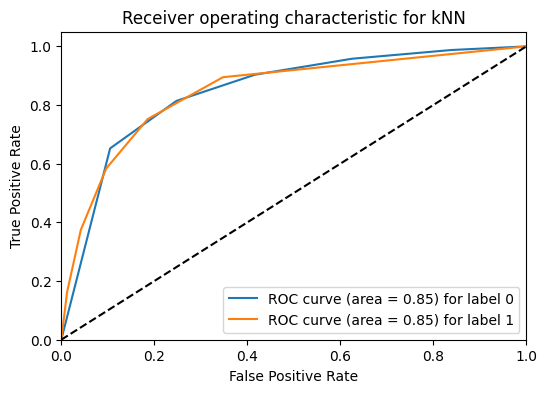

In [23]:
# kNN
knn = KNeighborsClassifier()
knn_model = MultiOutputClassifier(estimator=knn)

# kNN
knn_model.fit(x_train, y_train)

# kNN
pred = knn_model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print('kNN Test accuracy: %.3f' % ( test_acc))

plot_roc_curve(knn_model, x_test, y_test, 'kNN')

Naive Bayes Test accuracy: 0.629


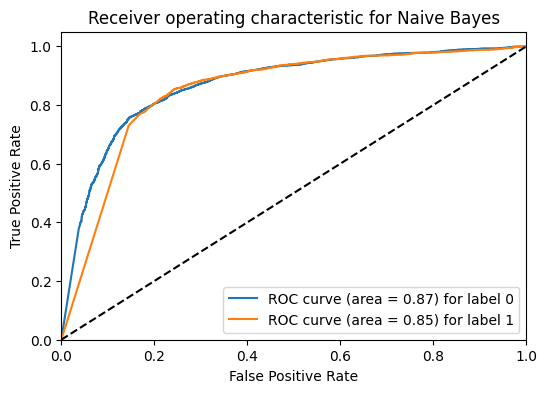

In [24]:
# Naive Bayes
nb = GaussianNB()
nb_model = MultiOutputClassifier(estimator=nb)

# Naive Bayes
nb_model.fit(x_train, y_train)

# Naive Bayes
pred = nb_model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print('Naive Bayes Test accuracy: %.3f' % ( test_acc))

plot_roc_curve(nb_model, x_test, y_test, 'Naive Bayes')

DecisionTree Test accuracy: 0.801


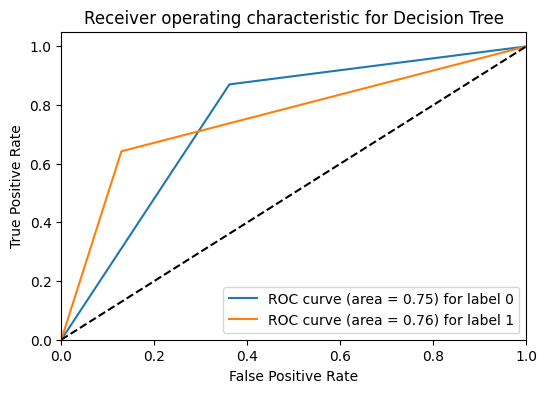

In [25]:
# DecisionTree
dtree = DecisionTreeClassifier()
dtree_model = MultiOutputClassifier(estimator=dtree)

# DecisionTree
dtree_model.fit(x_train, y_train)

# DecisionTree
pred = dtree_model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print('DecisionTree Test accuracy: %.3f' % ( test_acc))

plot_roc_curve(dtree_model, x_test, y_test, 'Decision Tree')

Logistic Regression Test accuracy: 0.856


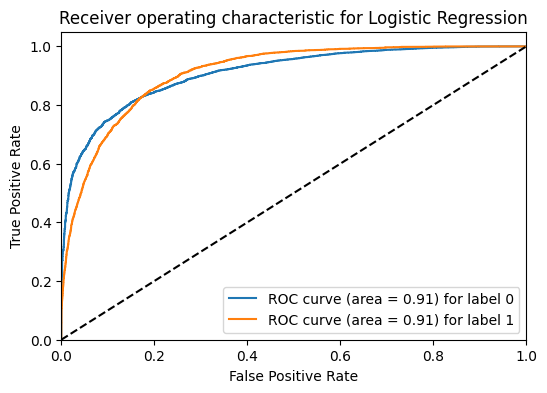

In [26]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg_model = MultiOutputClassifier(estimator=log_reg)

#LR
log_reg_model.fit(x_train, y_train)

#LR
pred_lr = log_reg_model.predict(x_test)
test_acc_lr = accuracy_score(y_test, pred_lr)
print('Logistic Regression Test accuracy: %.3f' % (test_acc_lr)) 

plot_roc_curve(log_reg_model, x_test, y_test, 'Logistic Regression')

RF Test accuracy: 0.814


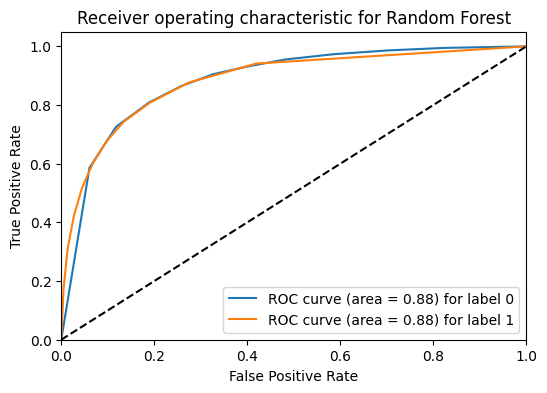

In [27]:
# Random forest
rf = RandomForestClassifier(n_estimators=10)
rf_model = MultiOutputClassifier(estimator=rf)

# RF
rf_model.fit(x_train, y_train)

# RF
pred = rf_model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print('RF Test accuracy: %.3f' % ( test_acc))  

plot_roc_curve(rf_model, x_test, y_test, 'Random Forest')

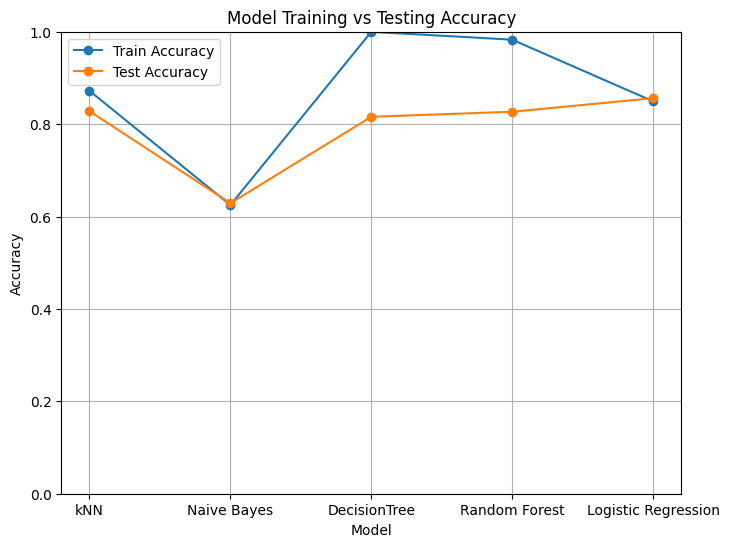

In [28]:
# Define models, wrapping with MultiOutputClassifier where needed
models = {
    'kNN': MultiOutputClassifier(KNeighborsClassifier()),
    'Naive Bayes': MultiOutputClassifier(GaussianNB()),
    'DecisionTree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=10),
    'Logistic Regression': MultiOutputClassifier(LogisticRegression())
}                                                                                              

# Train models and record accuracies
train_accuracies = {}
test_accuracies = {}

for name, model in models.items():
    model.fit(x_train, y_train)
    train_accuracies[name] = accuracy_score(y_train, model.predict(x_train))
    test_accuracies[name] = accuracy_score(y_test, model.predict(x_test))

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(list(train_accuracies.keys()), list(train_accuracies.values()), label='Train Accuracy', marker='o')
plt.plot(list(test_accuracies.keys()), list(test_accuracies.values()), label='Test Accuracy', marker='o')
plt.title('Model Training vs Testing Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.grid(True)
plt.show()


kNN Test Accuracy: 0.828
Naive Bayes Test Accuracy: 0.629
DecisionTree Test Accuracy: 0.817
Random Forest Test Accuracy: 0.828
Logistic Regression Test Accuracy: 0.856


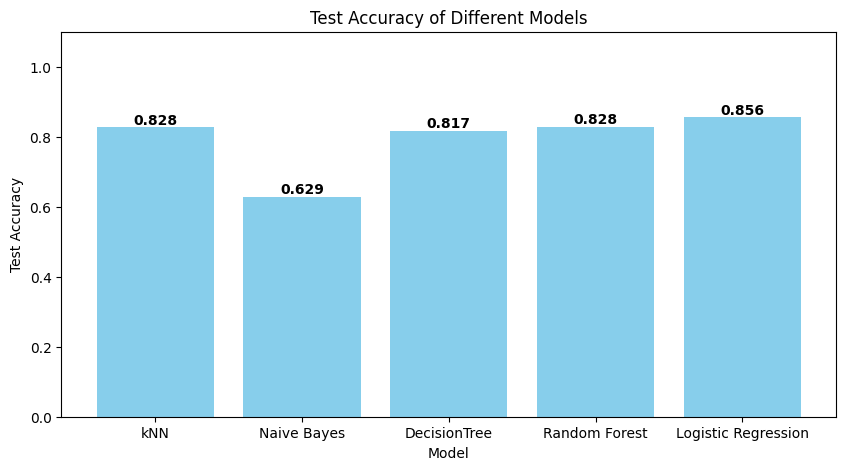

In [29]:
# Dictionary to store accuracy of each model
accuracies = {}

# Training and evaluating each model
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy:.3f}")

# Plotting accuracies
plt.figure(figsize=(10, 5))  # Adjusted figure size for better fit
bars = plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')

legend_labels = [f'{name} (Acc: {acc:.3f})' for name, acc in accuracies.items()]

# Adding text annotations on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', va='bottom',  # vertical alignment
             ha='center', color='black', fontweight='bold')  # horizontal alignment

plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of Different Models')
plt.ylim(0, 1.1)  # Adjusted to make room for text annotations
# Adding legend with the custom labels
#plt.legend(legend_labels, loc='upper right')  # Adjust location as needed
plt.show()

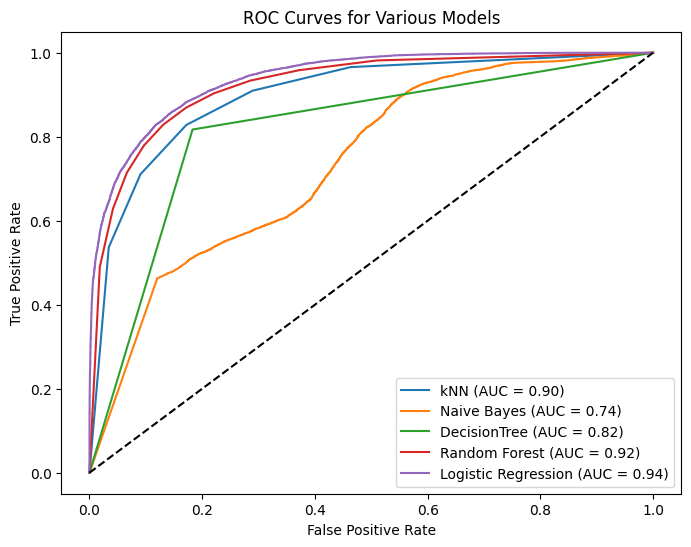

In [30]:
# Check if y_test needs binarization (for multi-class scenarios)
if len(np.unique(y_test)) > 2:
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
else:
    y_test_binarized = y_test

# Plot layout
plt.figure(figsize=(8, 6))

# Iterate over models, predict probabilities, and plot ROC curve
for name, model in models.items():
    try:
        # Predict probabilities
        y_prob = model.predict_proba(x_test)
        
        # Handling MultiOutputClassifier output
        if isinstance(y_prob, list):  # Check if output is a list
            # Assuming binary classification for each label, select the positive class probabilities
            y_prob = np.array([prob[:, 1] for prob in y_prob]).T
        
        # Compute ROC curve and ROC area for the positive class (binary case)
        if y_test_binarized.ndim == 1 or y_test_binarized.shape[1] == 1:
            fpr, tpr, _ = roc_curve(y_test_binarized, y_prob[:, 1])
        else:  # Multiclass scenario
            fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
        
        roc_auc = auc(fpr, tpr)
        
        # Plot
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    except Exception as e:
        print(f"Error for model {name}: {str(e)}")  # Catch any error to diagnose

# Plot baseline (chance level)
plt.plot([0, 1], [0, 1], 'k--')

# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(loc="lower right")
plt.show()

<Axes: xlabel='importance', ylabel='index'>

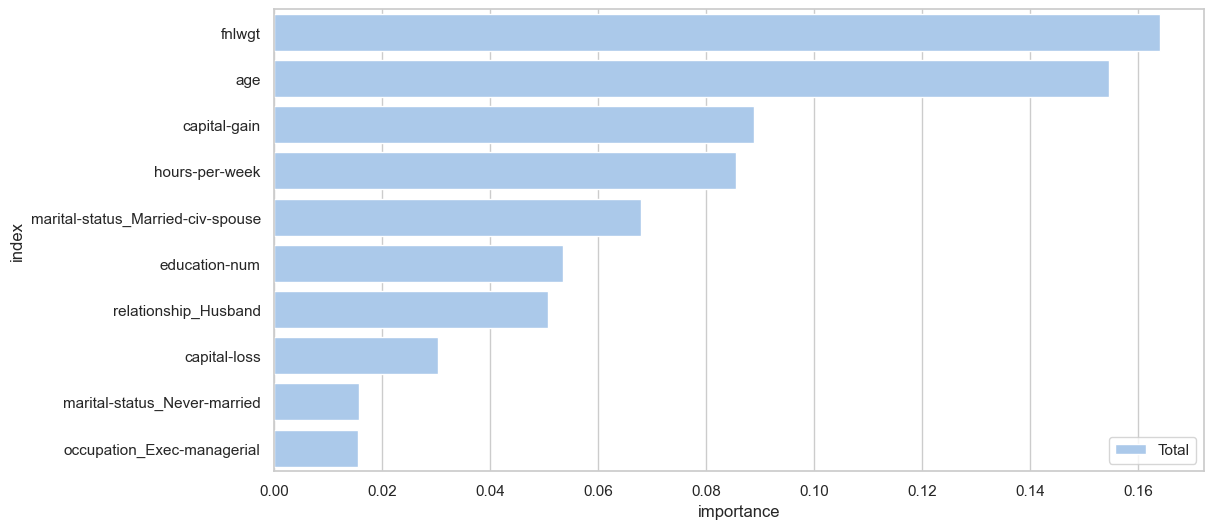

In [31]:
#Most important features

columns = norm_df.columns[:-2]
train = pd.DataFrame(np.atleast_2d(x_train), columns=columns)

feat_impts = []
for clf in rf_model.estimators_:
    feat_impts.append(clf.feature_importances_)
feature_importances = pd.DataFrame(np.mean(feat_impts, axis=0), 
                                   index = train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 6))

sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances[0:10],
            label="Total", color="b")